Found 17524 files belonging to 8 classes.
Found 4384 files belonging to 8 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 254s 427ms/step - accuracy: 0.6971 - loss: 0.9337 - val_accuracy: 0.8396 - val_loss: 0.4132
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 392ms/step - accuracy: 0.8427 - loss: 0.4607 - val_accuracy: 0.8688 - val_loss: 0.3707
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 213s 388ms/step - accuracy: 0.8490 - loss: 0.4244 - val_accuracy: 0.8611 - val_loss: 0.3566
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 392ms/step - accuracy: 0.8533 - loss: 0.4064 - val_accuracy: 0.8709 - val_loss: 0.3452
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 392ms/step - accuracy: 0.8586 - loss: 0.3884 - val_accuracy: 0.8679 - val_loss: 0.3456
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 217s 395ms/step - accuracy: 0.8617 - loss: 0.3793 - val_accuracy: 0.8736 - val_loss: 0.3409
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 213s 389ms/step - accuracy: 0.8598

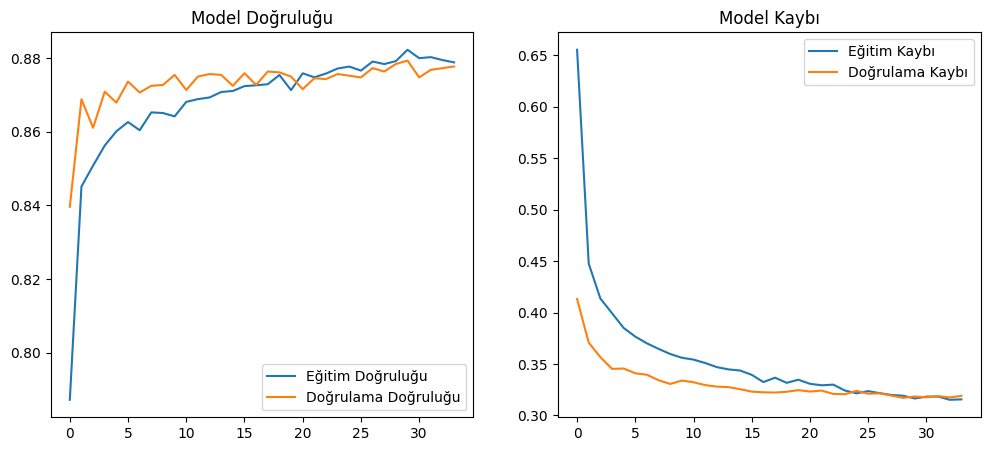

✅ Model başarıyla eğitildi ve kaydedildi!


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/train"
test_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/test"
img_size = (224, 224)
batch_size = 32
epochs = 50  # İlk eğitim için epoch sayısı


# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# EfficientNetB0 modelini yükle (transfer öğrenme)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)


# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('efficientnetb0_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

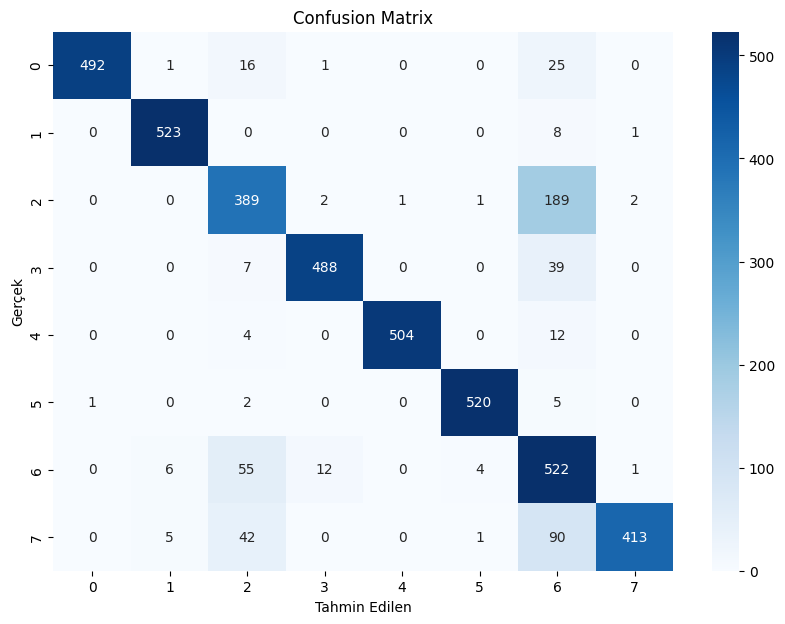

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

Attention

In [3]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Activation

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = tf.reduce_max
        self.dense1 = Dense(units=1, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(units=1, kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, -1))
        self.add = Add()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()

    def call(self, inputs):
        channel = inputs.shape[-1]
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        
        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        avg_pool = self.dense1(avg_pool)
        max_pool = self.dense1(max_pool)
        
        avg_pool = self.dense2(avg_pool)
        max_pool = self.dense2(max_pool)
        
        # Add and Sigmoid
        channel_attention = self.add([avg_pool, max_pool])
        channel_attention = self.activation(channel_attention)
        
        return self.multiply([inputs, channel_attention])

In [4]:
from tensorflow.keras.layers import Conv2D, Concatenate

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.concat = Concatenate(axis=-1)
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')
        self.multiply = Multiply()

    def call(self, inputs):
        # Average Pooling and Max Pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate along the channel axis
        concat = self.concat([avg_pool, max_pool])
        
        # Convolution layer
        spatial_attention = self.conv(concat)
        
        return self.multiply([inputs, spatial_attention])

In [5]:
from tensorflow.keras.models import Model

# EfficientNetB0 modelini yükle (transfer öğrenme)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Base model'in çıktısını al
x = base_model.output

# Channel Attention ekle
x = ChannelAttention()(x)

# Spatial Attention ekle
x = SpatialAttention()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Çıkış katmanı
output = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Yeni modeli oluştur
model = Model(inputs=base_model.input, outputs=output)

In [7]:
# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_attention_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 242s 410ms/step - accuracy: 0.8817 - loss: 0.3145 - val_accuracy: 0.8766 - val_loss: 0.3163
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 211s 385ms/step - accuracy: 0.8823 - loss: 0.3095 - val_accuracy: 0.8786 - val_loss: 0.3154
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 209s 382ms/step - accuracy: 0.8836 - loss: 0.3052 - val_accuracy: 0.8780 - val_loss: 0.3173
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 208s 380ms/step - accuracy: 0.8797 - loss: 0.3054 - val_accuracy: 0.8791 - val_loss: 0.3133
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 214s 389ms/step - accuracy: 0.8839 - loss: 0.3052 - val_accuracy: 0.8793 - val_loss: 0.3148
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 212s 387ms/step - accuracy: 0.8851 - loss: 0.3039 - val_accuracy: 0.8784 - val_loss: 0.3147
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 213s 388ms/step - accuracy: 0.8813 - loss: 0.3057 - val_accuracy: 0.8809 - val_loss: 0.3127
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 212s 388ms/step - accuracy: 0.8850 -

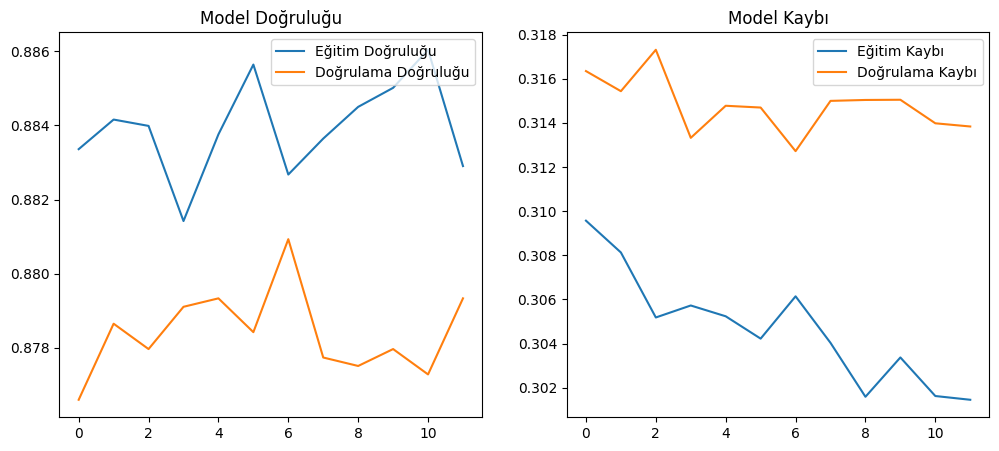

✅ Model başarıyla eğitildi ve kaydedildi!


In [8]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('efficientnetb0_attention_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

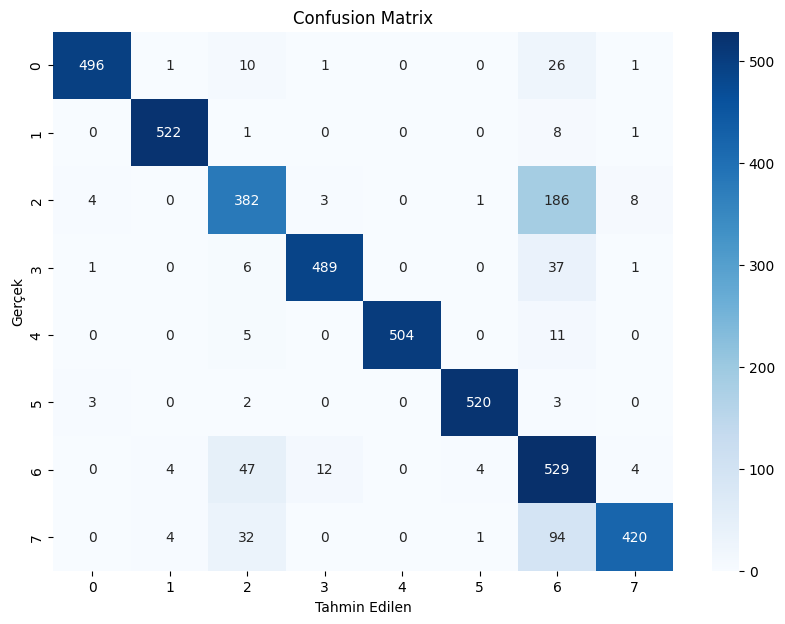

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()